# Linear Regression

## Importing Required Libraries

In [1]:
import matplotlib.pyplot as plt
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


## Generating Data

We begin by generating a test dataset by inserting gaussian noise to a cubic function $f(x) = ax^{3} + bx^{2} + cx + d$. The constants $a$, $b$, $c$ and $d$ will be chosen arbitrarily and the outputted dataset will be saved for future model learning.   

```{dropdown}
this should somehow appear in a dropdown
```

In [2]:
def f(x):
    return 0.7 * (x**3) - 7 * (x**2) + 1 * (x) + 5

In [3]:
X = torch.linspace(-5, 11, 1000, device=device)
Y = f(X) + 20 * torch.randn(X.shape[0], device=device)

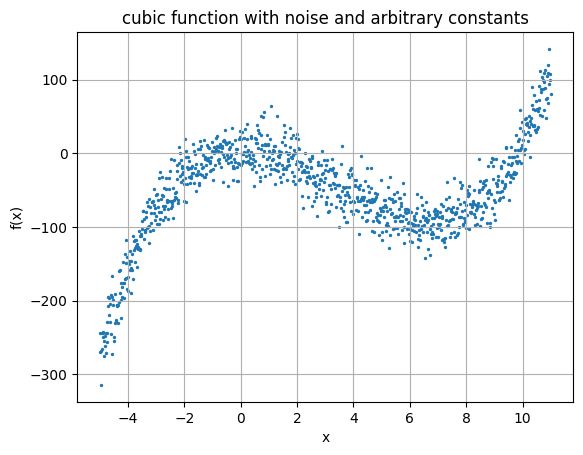

In [4]:
plt.scatter(X.cpu(), Y.cpu(), s=2)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('cubic function with noise and arbitrary constants')
plt.grid(True)

## Creating Linear Model

We now define a linear model that we will train with the generated data in order to *learn* the arbitrarily chosen parameters in the previous step.

Our model is a function of $x$, parameterized by weights $a_0,\, a_1,\, a_2,\, a_3$ and will be defined as follows:

$$
\begin{equation}
    f^*(x; a_0,\, a_1,\, a_2,\, a_3) = a_0x^3 + a_1x^2 + a_2x + a_3
\end{equation}
$$

For coding convenience, we store the constants in a **numpy array:** `a = [a0, a1, a2, a3]`.

In [5]:
a = torch.zeros(4, device=device)

def f_star(x):
    return a[0]*(x**3) + a[1]*(x**2) + a[2]*x + a[3]

The *loss function* which finds the error between our linear model's prediction $f^*(x)$ and the ground truth value $f(x)$ is optimizing the parameters and is thus a function of $\mathbf{a}$ and parametersized by $x$:

$$
\begin{equation}
    L(\mathbf{a};x) = \frac{1}{2n}\sum (f^*(x;\mathbf{a}) - f(x))^2 \tag{2}
\end{equation}
$$

In [6]:
def Loss(X, Y):
    return (1/2) * torch.mean((f_star(X) - Y)**2)

## Stochastic Gradient Descent

The *gradient* of this loss function $w.r.t$ our unkonwn weights $\mathbf{a} = [a_0, \, a_1, \, a_2, \, a_3]$ is calculated:

$$
\begin{align*}
    \frac{d}{d\mathbf{a}} L(\mathbf{a}; x) &= \frac{d}{d\mathbf{a}} \left[ \frac{1}{2n}\sum (f^*(x;\mathbf{a}) - f(x))^2 \right] \\ \\
                      &= \frac{1}{n} \sum (f^*(x;\mathbf{a}) - f(x)) \cdot (\frac{d}{d\mathbf{a}} f^*(x;\mathbf{a})) \\ \\
                      &= \frac{1}{n} \sum (f^*(x;\mathbf{a}) - f(x)) \cdot \left[ \begin{array}{c} x^3 \\ x^2 \\ x \\ 1 \end{array} \right]
\end{align*}
$$

In [7]:
def gradient(X, Y):

    err = f_star(X) - Y
    X_sq = X**2
    X_cb = X_sq * X

    return torch.tensor([
        torch.mean(err * X_cb),
        torch.mean(err * X_sq),
        torch.mean(err * X),
        torch.mean(err * 1)
    ], device=device)

We use this gardient along with a learning rate $\alpha$ in the **stochastic gradient descent** algorithm to *learn* the true constants (weights).

In [8]:
# randomization utility function
def randomize_arrays(arrays):
    indices = torch.randperm(arrays[0].size(0), device=device)
    for arr in arrays:
        arr[:] = arr[indices]

In [9]:
samples = torch.randperm(X.size(0))

X_randomized = torch.clone(X)[samples]
Y_randomized = torch.clone(Y)[samples]

X_train = X_randomized[:int(X_randomized.size(0)*0.95)]
Y_train = Y_randomized[:int(Y_randomized.size(0)*0.95)]

X_test = X_randomized[int(X_randomized.size(0)*0.95):]
Y_test = Y_randomized[int(Y_randomized.size(0)*0.95):]

# randomize_arrays([X_train, Y_train])

lr = 0.0000005
epochs = 30000
runs = []

batch_size = int(len(X_train)*0.5)

print("Starting training...")
print(f"current weights: {a}")
print(f"true weights: {[0.7, -7, 1, 5]}")
print()

for e in range(epochs):

    randomize_arrays([X_train, Y_train])

    for batch in range(0, len(X_train), batch_size):
        
        if (batch + batch_size) > len(X_train):
            X_batch = X_train[batch:]
            Y_batch = Y_train[batch:]
        else:
            X_batch = X_train[batch:batch+batch_size]
            Y_batch = Y_train[batch:batch+batch_size]

        # compute the gradient
        grad = gradient(X_batch, Y_batch)

        # update the parameters
        a -= lr * grad
        
    if (e % 100 == 0):
        # compute the training and testing loss
        runs.append([e, a.detach().cpu(), Loss(X_train, Y_train), Loss(X_test, Y_test)])
        print(f"epoch: {e}, gradient: {torch.round(grad)}, updated weights: {torch.round(runs[-1][1])}, train loss: {torch.round(runs[-1][2])}, test loss: {torch.round(runs[-1][3])}")
        print()

    if (e % 1000 == 0) and (e != 0):
        if((runs[-10][3] - runs[-1][3]) < 0.01):
            print("convergence, stopping training")
            break
        if ((runs[-10][3] - runs[-1][3]) < 1):
            lr /= 10

Starting training...
current weights: tensor([0., 0., 0., 0.], device='cuda:0')
true weights: [0.7, -7, 1, 5]

epoch: 0, gradient: tensor([1807., 1126.,   54.,   51.], device='cuda:0'), updated weights: tensor([-0., -0., -0., -0.]), train loss: 3423.0, test loss: 3554.0

epoch: 100, gradient: tensor([1114., 1019.,   39.,   49.], device='cuda:0'), updated weights: tensor([-0., -0., -0., -0.]), train loss: 3325.0, test loss: 3440.0

epoch: 200, gradient: tensor([513., 967.,  23.,  47.], device='cuda:0'), updated weights: tensor([0., -0., -0., -0.]), train loss: 3242.0, test loss: 3345.0

epoch: 300, gradient: tensor([-712.,  869.,    8.,   47.], device='cuda:0'), updated weights: tensor([0., -0., -0., -0.]), train loss: 3162.0, test loss: 3253.0

epoch: 400, gradient: tensor([458., 885.,  31.,  44.], device='cuda:0'), updated weights: tensor([0., -0., -0., -0.]), train loss: 3084.0, test loss: 3163.0

epoch: 500, gradient: tensor([1576.,  999.,   34.,   46.], device='cuda:0'), updated we

In [10]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

In [11]:
# final results

# data
fig, ax = plt.subplots()
ax.plot(X_train.cpu(), Y_train.cpu(), 'b.', markersize=2, label='train data')
ax.plot(X_test.cpu(), Y_test.cpu(), 'k.', markersize=10, label='test data')

# model
samples = torch.arange(0, len(X), len(X)//50)
X_samples = X[samples]
Y_samples = Y[samples]

line, = ax.plot([], [], 'r-', label='model')

def init():
    line.set_data([], [])
    return line,

def update(frame):
    global a
    a = runs[frame][1]
    line.set_data(X_samples.cpu(), f_star(X_samples).cpu())
    return line,

ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('fitting cubic function')
ax.legend()
ax.grid(True)

ani = FuncAnimation(fig, update, frames=range(len(runs)), init_func=init, blit=True, interval=1000//30)

plt.close(fig)

ani.save("modelfit_animation.gif", writer=PillowWriter(fps=30))

![Visuallizing Model Fitting Data](./modelfit_animation.gif)